In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn

### Load and Display Images

In [2]:
salinas = np.load('salinas.npy', allow_pickle=True)
salinas_gt = np.load('salinas_gt.npy', allow_pickle=True)
print(salinas.shape)
print(salinas_gt.shape)

(512, 217, 204)
(512, 217)


In [3]:
indiana_pines = np.load('indianapines.npy', allow_pickle=True)
indiana_pines_gt = np.load('indianapines_gt.npy', allow_pickle=True)
print(indiana_pines.shape)
print(indiana_pines_gt.shape)

(145, 145, 200)
(145, 145)


In [4]:
def plot_RGB(image):
    imageRGB = np.array(image[:, :, [30, 15, 2]], dtype=float)

    pmin,pmax = np.percentile(imageRGB, (1,99), axis=(0,1))
    print(pmin, pmax)
    imageRGB_pimped = imageRGB.copy()

    for i in range(pmin.size):
        imageRGB_pimped[:,:,i] = (imageRGB[:,:,i] - pmin[i]) / (pmax[i] - pmin[i])

    imageRGB_pimped[imageRGB_pimped < 0] = 0
    imageRGB_pimped[imageRGB_pimped > 1] = 1

    plt.figure(figsize=(5,5))
    plt.imshow(imageRGB_pimped)
    plt.show()

[ 600. 1045.  474.] [3747. 3107.  927.]


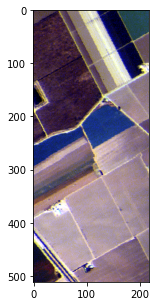

In [5]:
plot_RGB(salinas)

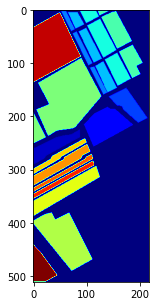

In [6]:
plt.figure(figsize=(5,5))
plt.imshow(salinas_gt, cmap='jet')

[2353. 2761. 3833.] [5442.   6051.76 4946.  ]


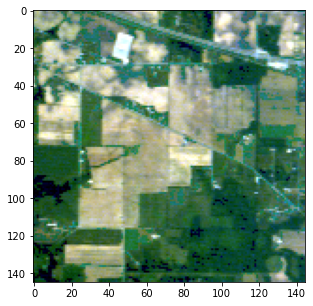

In [7]:
plot_RGB(indiana_pines)

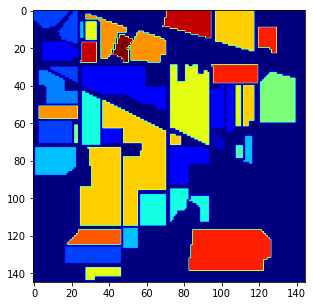

In [8]:
plt.figure(figsize=(5,5))
plt.imshow(indiana_pines_gt, cmap='jet')

### PCA

In [9]:
def flatten_image(X):
    return X.reshape((-1, X.shape[-1]))

X1 = flatten_image(salinas)
Y1 = salinas_gt.flatten()
print(X1.shape)
print(Y1.shape)

X2 = flatten_image(indiana_pines)
Y2 = indiana_pines_gt.flatten()
print(X2.shape)
print(Y2.shape)

(111104, 204)
(111104,)
(21025, 200)
(21025,)


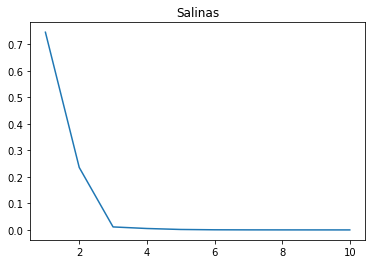

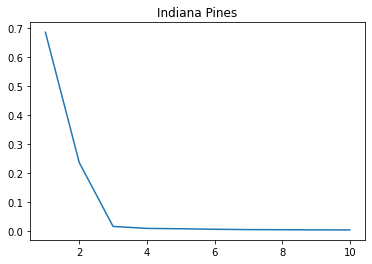

In [10]:
from sklearn import decomposition

def pca_components(X, name):
    pca = decomposition.PCA(n_components=10)
    pca.fit(X)

    plt.plot(np.arange(1, 11), pca.explained_variance_ratio_)
    plt.title(name)
    plt.show()

pca_components(X1, "Salinas")
pca_components(X2, "Indiana Pines")

Variance greater than 0.999: 5


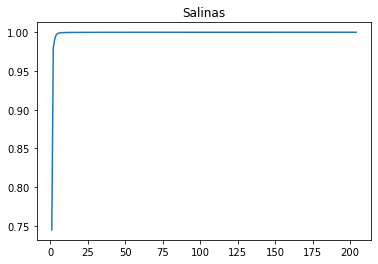

Variance greater than 0.999: 68


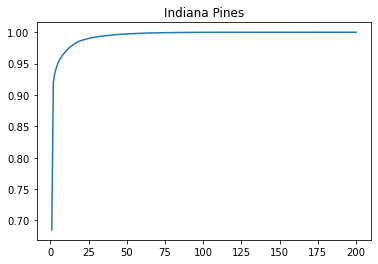

In [11]:
def pca_components_cumsum(X, name):
    pca = decomposition.PCA()
    pca.fit(X)

    variances = np.cumsum(pca.explained_variance_ratio_)
    print("Variance greater than 0.999:", np.argmax(variances > 0.999))

    plt.plot(np.arange(1, X.shape[-1] + 1), variances)
    plt.title(name)
    plt.show()

pca_components_cumsum(X1, "Salinas")
pca_components_cumsum(X2, "Indiana Pines")

In [12]:
pca1 = decomposition.PCA(n_components=20)
pca1.fit(X1)
print(pca1.components_.shape)

X1_pca = pca1.transform(X1)
print(X1_pca.shape)

(20, 204)
(111104, 20)


In [13]:
pca2 = decomposition.PCA(n_components=68)
pca2.fit(X2)
print(pca2.components_.shape)

X2_pca = pca2.transform(X2)
print(X2_pca.shape)

(68, 200)
(21025, 68)


### Classifier

In [ ]:
from sklearn.utils import class_weight
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

In [24]:
def class_weights(y):
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weights = dict(zip(np.arange(16), class_weights))

    print(class_weights)

    return class_weights

class_weights1 = class_weights(Y1)
class_weights2 = class_weights(Y2)

{0: 0.11470872157551042, 1: 3.2531256405001026, 2: 1.7540336585519876, 3: 3.3074541557513695, 4: 4.68832812895603, 5: 2.4404516100689717, 6: 1.650803084557895, 7: 1.826076952155548, 8: 0.5798535544108514, 9: 1.0536078368152033, 10: 1.9937551591716614, 11: 6.11940956157744, 12: 3.3915565188192556, 13: 7.134857436424351, 14: 6.107971412864211, 15: 0.8992197869791835}
{0: 0.11477029564609809, 1: 26.88618925831202, 2: 0.8660817268083704, 3: 1.490077958894401, 4: 5.218416480516257, 5: 2.5605894531725735, 6: 1.6941982272361, 7: 44.17016806722689, 8: 2.5873738616785626, 9: 61.838235294117645, 10: 1.27239167271847, 11: 0.5037738109500419, 12: 2.08560658664815, 13: 6.032998565279771, 14: 0.9776796093931643, 15: 3.2040536421822616}


In [25]:
clf = SGDClassifier(shuffle=True, early_stopping=True, class_weight=class_weights1, random_state=1)

### One vs rest classifier

In [76]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

In [92]:
clf = OneVsRestClassifier(LinearSVC(random_state=1, max_iter=100), n_jobs=4)

In [27]:
clf_pipeline = OneVsRestClassifier(LinearSVC(random_state=1, max_iter=1000), n_jobs=4)
clf = make_pipeline(StandardScaler(), clf_pipeline)

### One vs one classifier


In [ ]:
from sklearn.multiclass import OneVsOneClassifier

In [33]:
clf_pipeline = OneVsOneClassifier(LinearSVC(random_state=1, max_iter=1000), n_jobs=6)
clf = make_pipeline(StandardScaler(), clf_pipeline)

### Custom Classifier

In [ ]:
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import clone
from sklearn.calibration import CalibratedClassifierCV

In [93]:
class MyClassifier(ClassifierMixin):
    def __init__(self, clf, class_weights=None):
        self.clf_ = clf
        self.class_weights_ = class_weights
    
    def fit(self, X, y):
        self.label_binarizer_ = LabelBinarizer(sparse_output=False)
        Y = self.label_binarizer_.fit_transform(y)
        columns = Y.T
        self.estimators_ = []

        for i, y_bin in enumerate(columns[1:]):
            print(i)
            clf_copy = clone(self.clf_)
            self.estimators_.append(clf_copy.fit(X, y_bin))
            
#         self.estimators_ = Parallel(n_jobs=self.n_jobs)(delayed(_fit_binary)(
#             self.estimator, X, column, classes=[
#                 "not %s" % self.label_binarizer_.classes_[i],
#                 self.label_binarizer_.classes_[i]])
#             for i, column in enumerate(columns))
        
    def predict(self, X):
        maxima = np.full(X.shape[0], -np.inf)
        argmaxima = np.zeros(X.shape[0], dtype=int)

        for i, e in enumerate(self.estimators_):
            proba_y = e.predict_proba(X)[:,1]
            np.maximum(maxima, proba_y, out=maxima)
            argmaxima[maxima == proba_y] = i + 1
            
        argmaxima[maxima < 0.3] = 0
        return argmaxima

In [94]:
clf_pipeline = MyClassifier(CalibratedClassifierCV(LinearSVC(random_state=1, max_iter=1000), cv=3, n_jobs=3))
clf = make_pipeline(StandardScaler(), clf_pipeline)

### Fit

In [85]:
clf.fit(X1, Y1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('myclassifier',
                 <__main__.MyClassifier object at 0x7f4ed7631a60>)])

In [95]:
clf.fit(X2, Y2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('myclassifier',
                 <__main__.MyClassifier object at 0x7f4ed5b653a0>)])

### Testing

In [86]:
from sklearn.metrics import plot_confusion_matrix, classification_report

0.7944808467741935
              precision    recall  f1-score   support

           0       0.81      0.90      0.85     56975
           1       0.79      1.00      0.88      2009
           2       0.96      0.86      0.91      3726
           3       0.72      0.35      0.48      1976
           4       0.82      0.93      0.87      1394
           5       0.66      0.99      0.79      2678
           6       0.86      0.99      0.92      3959
           7       0.91      0.99      0.95      3579
           8       0.89      0.30      0.45     11271
           9       0.92      0.74      0.82      6203
          10       0.93      0.35      0.51      3278
          11       0.97      0.31      0.46      1068
          12       0.72      0.88      0.79      1927
          13       0.69      0.95      0.80       916
          14       0.81      0.06      0.11      1070
          15       0.55      0.84      0.66      7268
          16       0.95      0.93      0.94      1807

    acc

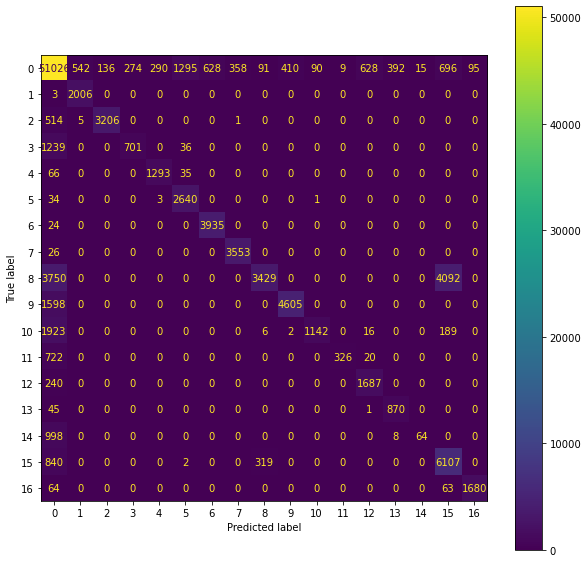

In [87]:
print(clf.score(X1, Y1))
print(classification_report(Y1, clf.predict(X1)))

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf, X1, Y1, ax=ax)
plt.show()

In [96]:
print(clf.score(X2, Y2))
print(classification_report(Y2, clf.predict(X2)))

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf, X2, Y2, ax=ax)
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

(111104,)
(512, 217)


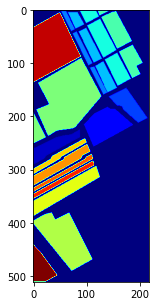

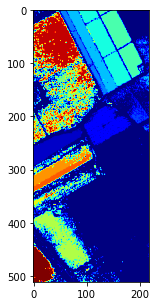

In [88]:
y1_predict = clf.predict(X1)
print(y1_predict.shape)

y1_predict_reshaped = y1_predict.reshape((salinas_gt.shape))
print(y1_predict_reshaped.shape)

plt.figure(figsize=(5,5))
plt.imshow(salinas_gt, cmap='jet')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(y1_predict_reshaped, cmap='jet')
plt.show()

(21025,)
(145, 145)


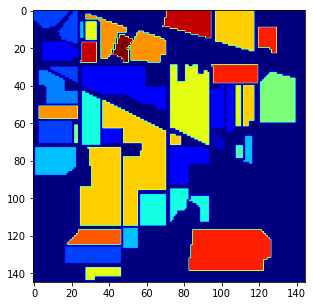

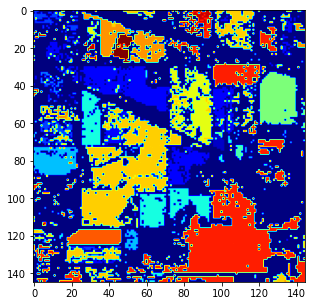

In [82]:
y2_predict = clf.predict(X2)
print(y2_predict.shape)

y2_predict_reshaped = y2_predict.reshape((indiana_pines_gt.shape))
print(y2_predict_reshaped.shape)

plt.figure(figsize=(5,5))
plt.imshow(indiana_pines_gt, cmap='jet')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(y2_predict_reshaped, cmap='jet')
plt.show()